**Import Libraries**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Load Datasets**

In [0]:
train_data = pd.read_csv("/content/drive/My Drive/Drug Reviews Dataset/drugsComTrain_raw.tsv", sep="\t", parse_dates=["date"])
test_data = pd.read_csv("/content/drive/My Drive/Drug Reviews Dataset/drugsComTest_raw.tsv", sep="\t", parse_dates=["date"])

Viewing first 5 samples of each dataset

In [0]:
train_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37


In [0]:
test_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,2012-02-28,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,2009-05-17,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,2017-09-29,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,2017-03-05,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,2015-10-22,4


Changing the dtype of *rating* column from float to integer

In [0]:
train_data = train_data.astype({'rating': 'int64'})
test_data = test_data.astype({'rating': 'int64'})

Creating a new column *sentiment* with the criteria:
* Negative (if rating < 6)
* Positive (if rating >= 6)

In [0]:
train_data['sentiment'] = train_data.rating.apply(lambda r: "negative" if r<6 else "positive")
test_data['sentiment'] = test_data.rating.apply(lambda r: "negative" if r<6 else "positive")

Shapes of the two datasets

In [0]:
print("Train DataFrame: ",train_data.shape)
print("Test DataFrame: ",test_data.shape)

Train DataFrame:  (161297, 8)
Test DataFrame:  (53766, 8)


Concatenating into one dataset

In [0]:
df = pd.concat([train_data, test_data], axis=0)

In [0]:
df = df.reset_index(drop=True)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Unnamed: 0   215063 non-null  int64         
 1   drugName     215063 non-null  object        
 2   condition    213869 non-null  object        
 3   review       215063 non-null  object        
 4   rating       215063 non-null  int64         
 5   date         215063 non-null  datetime64[ns]
 6   usefulCount  215063 non-null  int64         
 7   sentiment    215063 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 13.1+ MB


In [0]:
print("Overall DataFrame Shape: ",df.shape)

Overall DataFrame Shape:  (215063, 8)


**Exploratory Data Analysis (EDA)**

Checking for NULL values

In [0]:
df.isnull().sum()

Unnamed: 0        0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
sentiment         0
dtype: int64

There are 1194 NULL values in the *condition* column.

**Number of drugs per condition**

Next, I will be grouping the conditions by the drug name and sort each by the number of drugs a particular condition has in descending order.

In [0]:
condition_df = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

In [0]:
condition_df

condition
Not Listed / Othe                             253
Pain                                          219
Birth Control                                 181
High Blood Pressure                           146
Acne                                          127
                                             ... 
Steroid Responsive Inflammatory Conditions      1
Ectopic Pregnancy                               1
Diagnostic Bronchograms                         1
Systemic Candidiasis                            1
Epicondylitis, Tennis Elbow                     1
Name: drugName, Length: 916, dtype: int64

In [0]:
print("Total number of conditions: ",len(condition_df))

Total number of conditions:  916


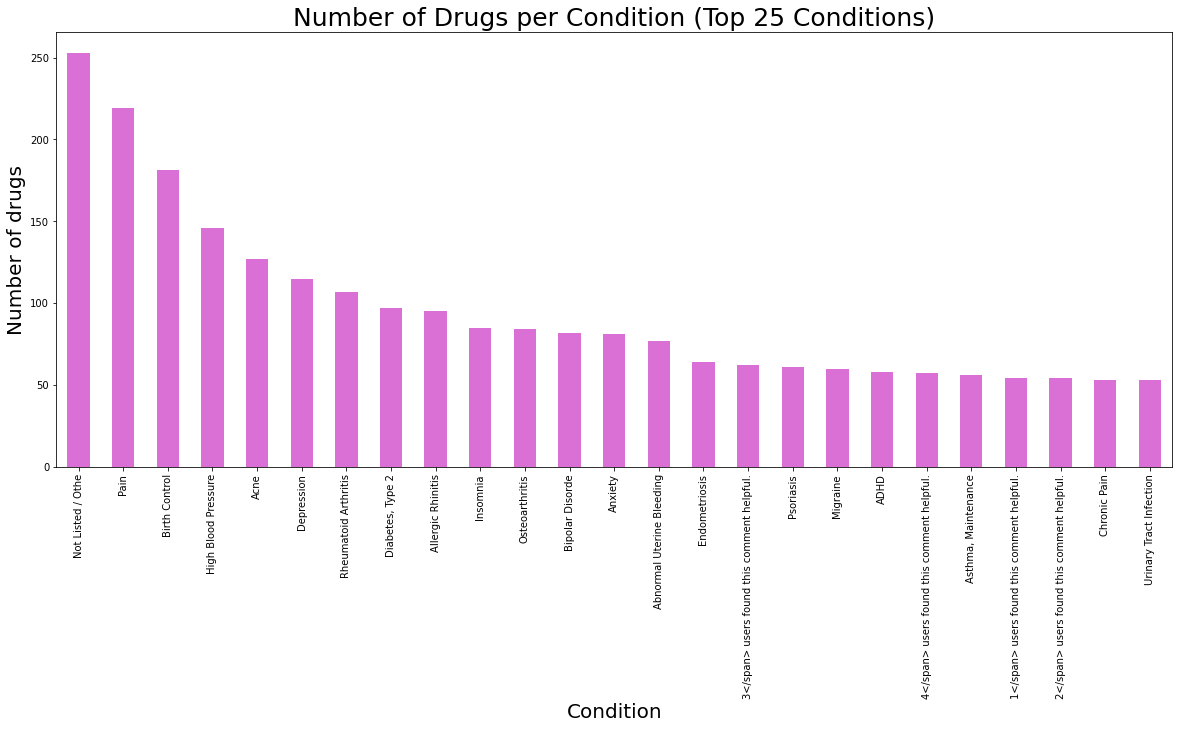

In [0]:
condition_df[0:25].plot(kind='bar', figsize=(20,8), fontsize=10, color='orchid')
plt.xlabel("Condition", fontsize=20)
plt.ylabel("Number of drugs", fontsize=20)
plt.title("Number of Drugs per Condition (Top 25 Conditions)", fontsize=25)
plt.show()

The total number of conditions in the data are 916. For *Pain*, there arre more than 200 drugs, *Birth Control* around 160, *High Blood Pressure* around 150, and so and so. However, some of them have values like "Not Listed / Othe", which the user might have forgot to while writing the review, and also "3< /span> users found this comment helpful", which seems to be an error in the scraping process. There will be more of such values (with different numbers before < /span>) and we will get rid of them later on data pre-proceesing.

**Ratings**

Let's see the number of reviews of each rating.

In [0]:
ratings = df['rating'].value_counts().sort_values(ascending=False)

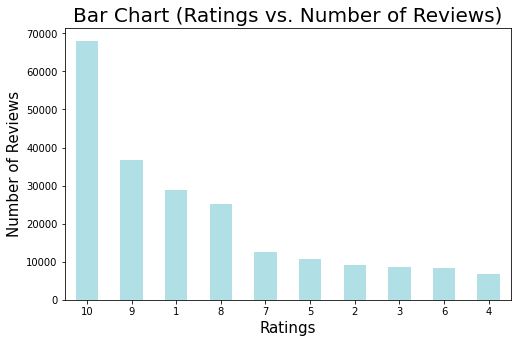

In [0]:
ratings.plot(kind='bar', figsize=(8,5), fontsize=10, color='powderblue')
plt.xlabel("Ratings", fontsize=15)
plt.xticks(rotation='horizontal')
plt.ylabel("Number of Reviews", fontsize=15)
plt.title("Bar Chart (Ratings vs. Number of Reviews)", fontsize=20)
plt.show()

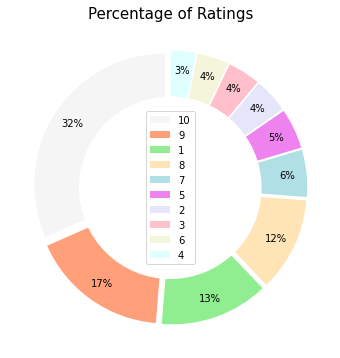

In [0]:
colors1 = ['whitesmoke','lightsalmon','lightgreen','moccasin','powderblue','violet','lavender','pink','beige','lightcyan']
explode = np.full(shape=10, fill_value=0.05, dtype='float64')
ratings.plot.pie(labels=None, colors=colors1, autopct='%1.0f%%', pctdistance=0.85, explode=explode, startangle=90, figsize=(6,6))
centre_circle = plt.Circle((0,0), 0.70, fc='white')
plt.gcf().gca().add_artist(centre_circle)
plt.legend(ratings.index, loc='center')
plt.xlabel("")
plt.ylabel("")
plt.title("Percentage of Ratings", fontsize=15)
plt.show()

More than 60000 (32%) reviews have a rating of 10, around 35000 (17%) have a rating of 9, slightly less than 30000 (13%) have a rating of 1, and the rest as depicted in the above charts.

**Yearly Reviews**

Next, let's see how many reviews have been recorded in each year starting 2008 to 2017.

In [0]:
reviews_per_year = df['date'].dt.year.value_counts().sort_index()

In [0]:
reviews_per_year

2008     6785
2009    15642
2010    11227
2011    15454
2012    13382
2013    16359
2014    16104
2015    36192
2016    46607
2017    37311
Name: date, dtype: int64

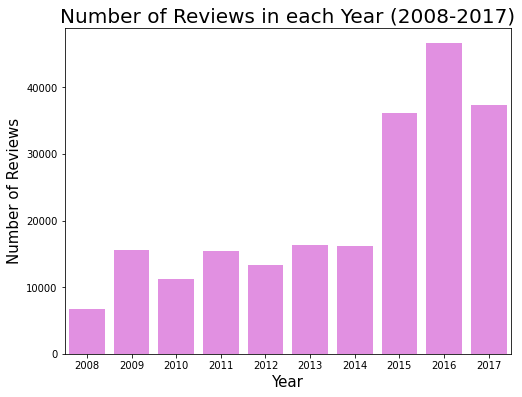

In [0]:
plt.figure(figsize=(8,6))
sns.barplot(reviews_per_year.index, reviews_per_year.values, color='violet')
plt.xlabel("Year", fontsize=15)
plt.ylabel("Number of Reviews", fontsize=15)
plt.title("Number of Reviews in each Year (2008-2017)", fontsize=20)
plt.show()

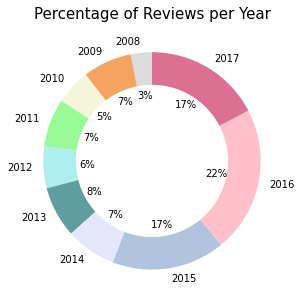

In [0]:
colors2 = ['gainsboro','sandybrown','beige','palegreen','paleturquoise','cadetblue','lavender','lightsteelblue','pink','palevioletred']
reviews_per_year.plot.pie(labels=reviews_per_year.index, colors=colors2, autopct='%1.0f%%', startangle=90, figsize=(5,5))
centre_circle = plt.Circle((0,0), 0.70, fc='white')
plt.gcf().gca().add_artist(centre_circle)
plt.xlabel("")
plt.ylabel("")
plt.title("Percentage of Reviews per Year", fontsize=15)
plt.show()

As you can see, the top three years when the most number of reviews have been recorded are 2016 (22%), 2015 (17%) and 2017 (17%).

**Monthly Reviews**

Next, let's see the number of monthly reviews in each year.

In [0]:
years = np.array(reviews_per_year.index)
indices = np.array([1,2,3,4,5,6,7,8,9,10,11,12], dtype='int64')
def get_monthly_reviews(year):
  curr_year_dates = df['date'][df['date'].dt.year == year].reset_index(drop=True)
  curr_year_monthly_reviews = curr_year_dates.dt.month.value_counts().reindex(indices).fillna(0)
  return curr_year_monthly_reviews

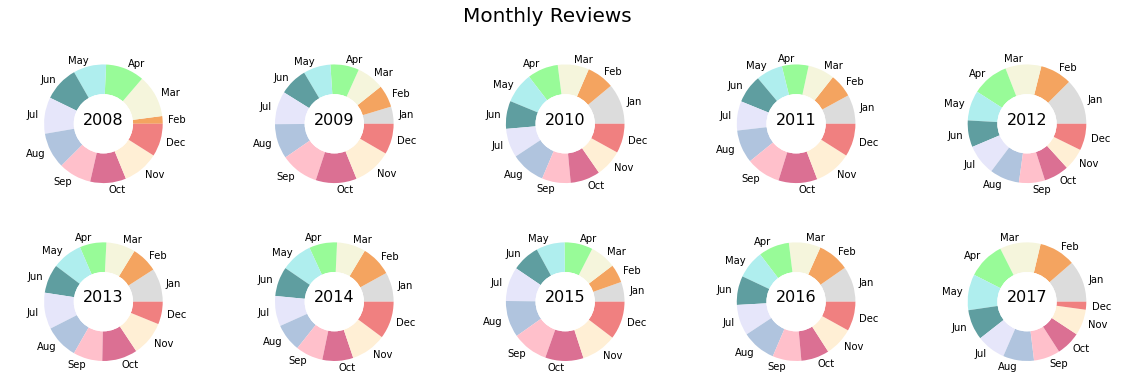

In [0]:
labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
colors3 = ['gainsboro','sandybrown','beige','palegreen','paleturquoise','cadetblue','lavender','lightsteelblue','pink','palevioletred','papayawhip','lightcoral']
fig, ax = plt.subplots(figsize=(20,6))
fig.suptitle("Monthly Reviews", fontsize=20)
plt.axis('off')

for i, y in enumerate(years):
  chart_data = get_monthly_reviews(y)
  ax = fig.add_subplot(2,5,i+1)
  chart_data.plot.pie(labels=labels, colors=colors3)
  circle = plt.Circle((0,0), 0.50, fc='white')
  plt.gcf().gca().add_artist(circle)
  ax.add_patch(circle)
  annot = ax.annotate(y, (0,0), fontsize=16, ha='center')
  ax.set_aspect('equal')
  plt.xlabel("")
  plt.ylabel("")

plt.show()

So, in all the years (2008 to 2017), the reviews have been almost equally recorded in each month.

**Count of Useful Drugs**

Now, let's see how many users have regarded a certain drug as useful.

In [0]:
usefulDrugs = df.groupby(['drugName'])['usefulCount'].nunique().sort_values(ascending=False)

In [0]:
usefulDrugs

drugName
Sertraline                           197
Citalopram                           195
Fluoxetine                           194
Celexa                               192
Prozac                               192
                                    ... 
Inspra                                 1
Insta-Glucose                          1
Insulin aspart / insulin degludec      1
Integra                                1
A + D Cracked Skin Relief              1
Name: usefulCount, Length: 3671, dtype: int64

In [0]:
print("Total number of drugs: ",len(usefulDrugs))

Total number of drugs:  3671


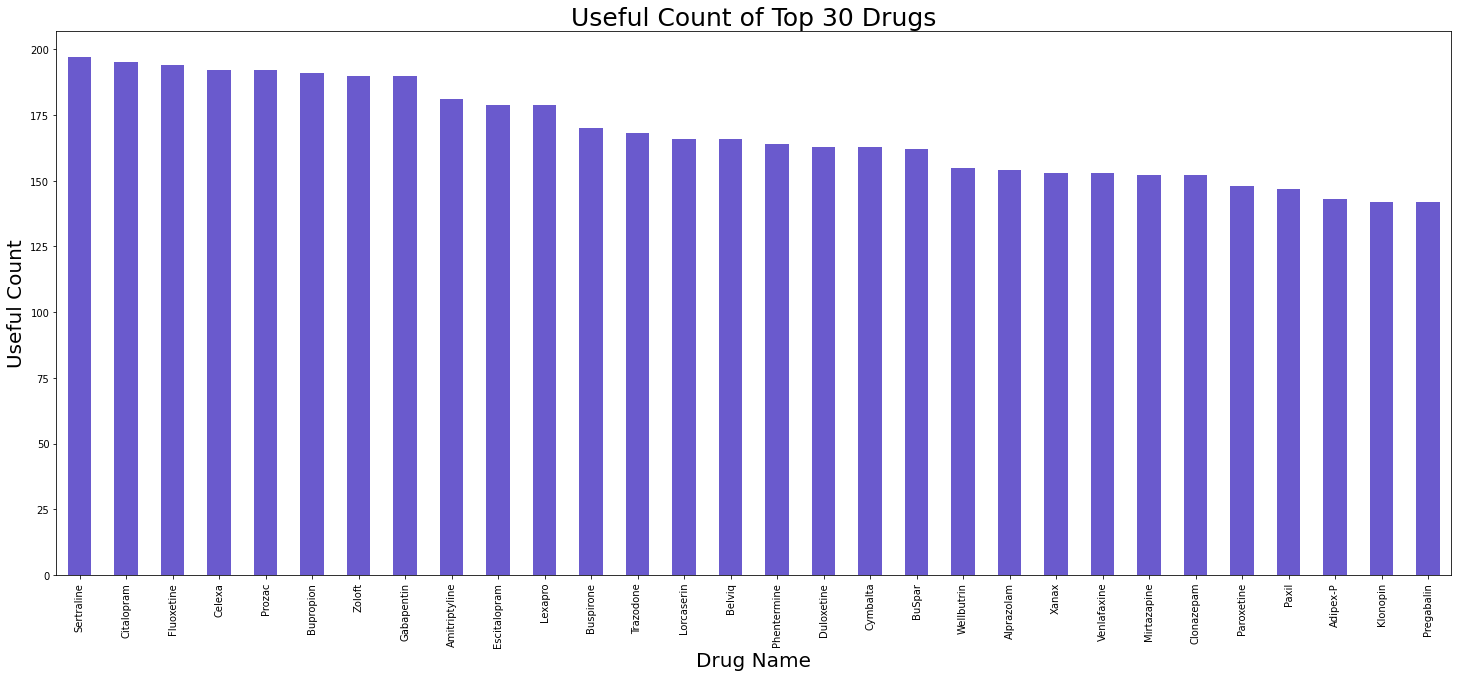

In [0]:
usefulDrugs[0:30].plot(kind='bar', figsize=(25,10), fontsize=10, color='slateblue')
plt.xlabel("Drug Name", fontsize=20)
plt.ylabel("Useful Count", fontsize=20)
plt.title("Useful Count of Top 30 Drugs", fontsize=25)
plt.show()

The entire data has a total of 3671 drugs, and a lot of users have regarded some of the drugs as useful. Examples are *Sertraline*, *Citalopram*, *Fluoxetine*, *Celexa*, *Prozac*, etc.

**Positive and Negative**

Finally, let's see the number of positive and negative reviews for each drug.

In [0]:
drug_sentiment = df.groupby(['drugName'])['sentiment'].value_counts().sort_index()

In [0]:
drug_sentiment

drugName                              sentiment
A + D Cracked Skin Relief             positive      1
A / B Otic                            positive      2
Abacavir / dolutegravir / lamivudine  negative     13
                                      positive     57
Abacavir / lamivudine                 positive      3
                                                   ..
ella                                  negative     20
                                      positive     51
femhrt                                negative      2
                                      positive      4
pHisoHex                              positive      1
Name: sentiment, Length: 5826, dtype: int64

In [0]:
drug_senti = drug_sentiment.groupby(['drugName', 'sentiment']).sum().unstack().fillna(0)

In [0]:
drug_senti

sentiment,negative,positive
drugName,,
A + D Cracked Skin Relief,0.0,1.0
A / B Otic,0.0,2.0
Abacavir / dolutegravir / lamivudine,13.0,57.0
Abacavir / lamivudine,0.0,3.0
Abacavir / lamivudine / zidovudine,0.0,1.0
...,...,...
ZzzQuil,3.0,0.0
depo-subQ provera 104,1.0,1.0
ella,20.0,51.0


In [0]:
positive_count = drug_senti['positive'].sort_values(ascending=False)
negative_count = drug_senti['negative'].sort_values(ascending=False)

In [0]:
print(str(positive_count.index[0])+' has '+str(int(positive_count[0]))+' positive reviews.')

Levonorgestrel has 3633 positive reviews.


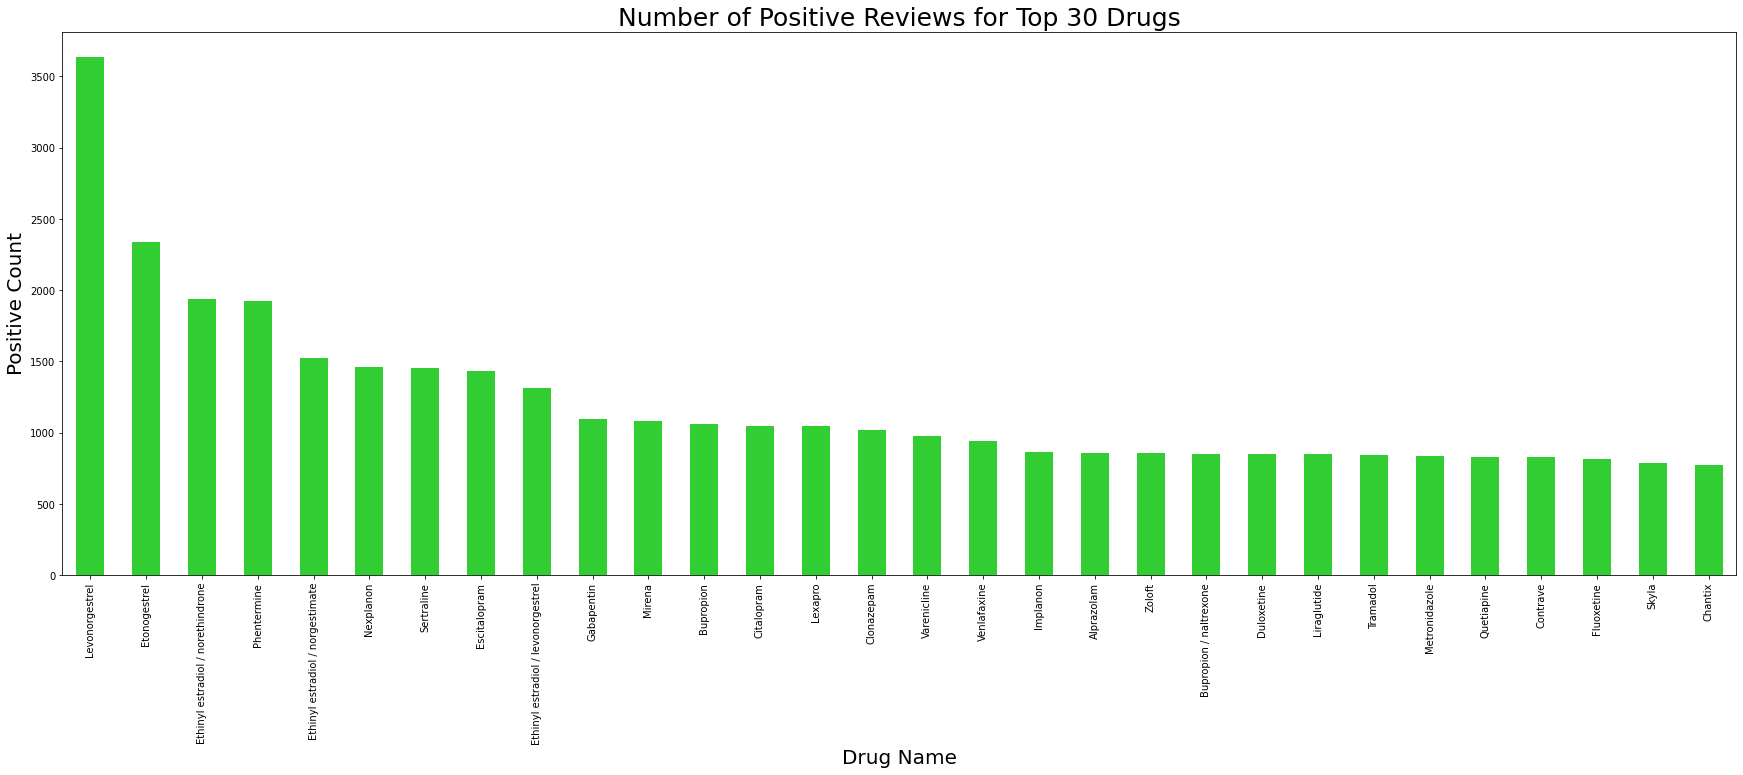

In [0]:
positive_count[0:30].plot(kind='bar', figsize=(30,10), fontsize=(10), color='limegreen')
plt.xlabel("Drug Name", fontsize=20)
plt.ylabel("Positive Count", fontsize=20)
plt.title("Number of Positive Reviews for Top 30 Drugs", fontsize=25)
plt.show()

The drug with most number of positive reviews is *Levonorgestrel*.

In [0]:
print(str(negative_count.index[0])+' has '+str(int(negative_count[0]))+' negative reviews.')

Etonogestrel has 2082 negative reviews.


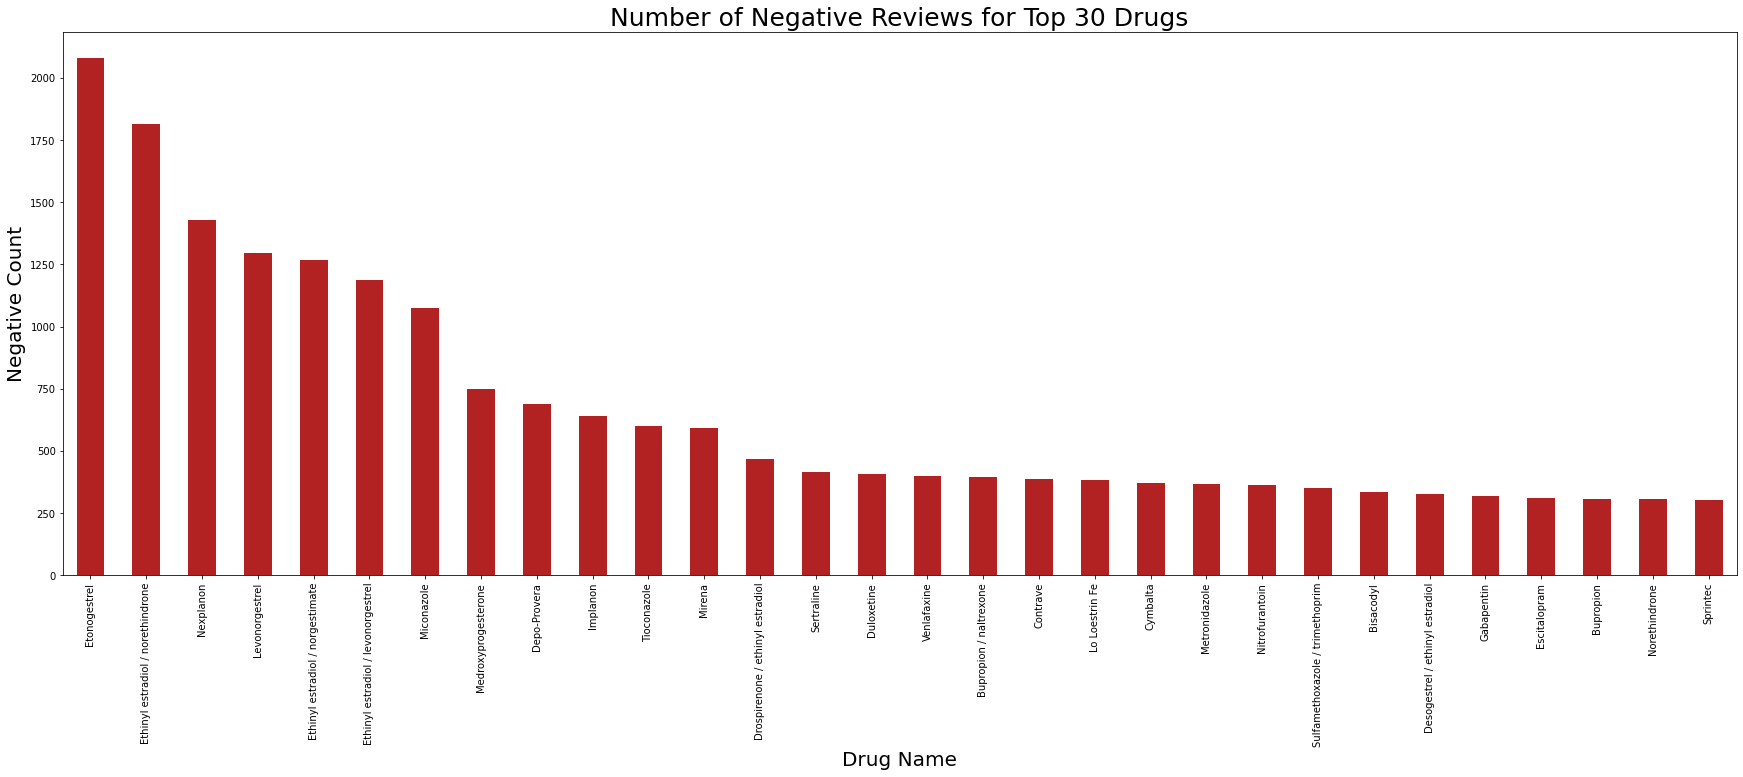

In [0]:
negative_count[0:30].plot(kind='bar', figsize=(30,10), fontsize=(10), color='firebrick')
plt.xlabel("Drug Name", fontsize=20)
plt.ylabel("Negative Count", fontsize=20)
plt.title("Number of Negative Reviews for Top 30 Drugs", fontsize=25)
plt.show()

The drug with most number of negative reviews is *Etonogestrel*.

Uploading the concatenated dataset onto my drive to pre-process the data in the coming notebook.

In [0]:
df.to_csv('DrugReviews.csv')
!cp DrugReviews.csv "drive/My Drive/Drug Reviews Dataset/"